In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

%load_ext autoreload
%autoreload 2

import copy
%matplotlib inline
import matplotlib.pyplot as plt
%pdb

<IPython.core.display.Javascript object>

Automatic pdb calling has been turned ON


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import argparse

model_dir = "./models/"
import model_archs
from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy, sws_replace, compressed_model
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets, get_layer_data
from retrain_layer import retrain_layer
retraining_epochs = 50


test_data_full = Variable(test_data(fetch = "data")).cuda()
test_labels_full = Variable(test_data(fetch = "labels")).cuda()
#val_data_full = Variable(search_validation_data(fetch = "data")).cuda()
#val_labels_full = Variable(search_validation_data(fetch = "labels")).cuda()


/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


0-component Mean: 2000.0 Variance: 1000.0
Non-zero component Mean: 100.0 Variance: 10.0
Layer Loss: 140498.391
Layer Loss: 169.435
Layer Loss: 17919.479
Layer Loss: 48.497
Layer Loss: 607.053
Layer Loss: 5.343
0-neglogprop Loss: -11055.582
Remaining-neglogprop Loss: -39147.242
Epoch: 10. Test Accuracy: 94.84 Prune Accuracy: 94.31 Sparsity: 98.07


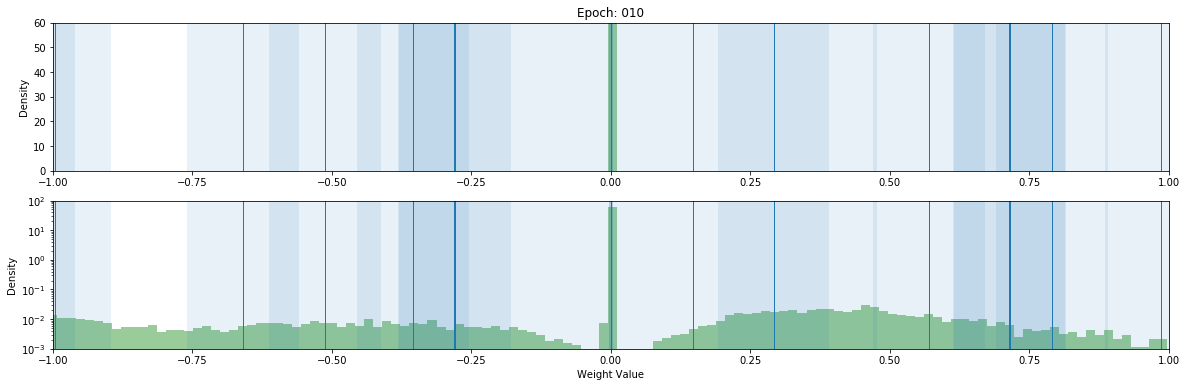

Epoch: 20. Test Accuracy: 95.49 Prune Accuracy: 94.82 Sparsity: 98.11


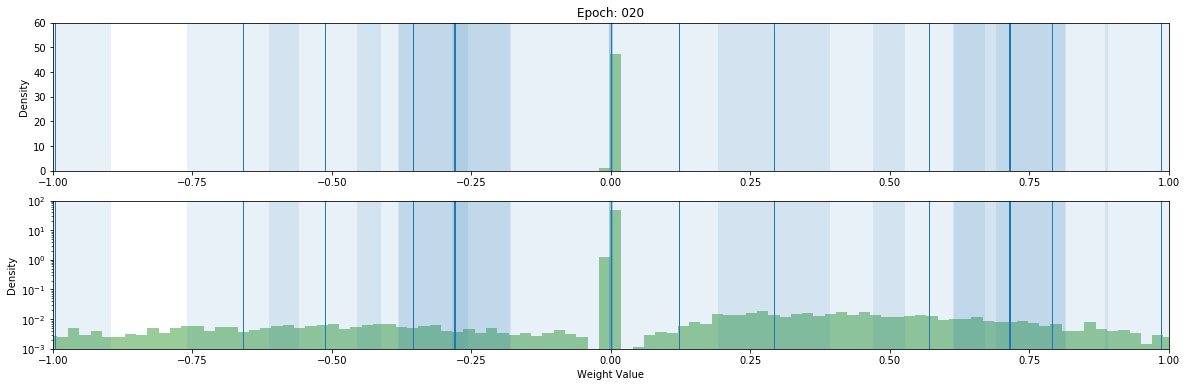

Epoch: 30. Test Accuracy: 95.54 Prune Accuracy: 94.70 Sparsity: 98.16


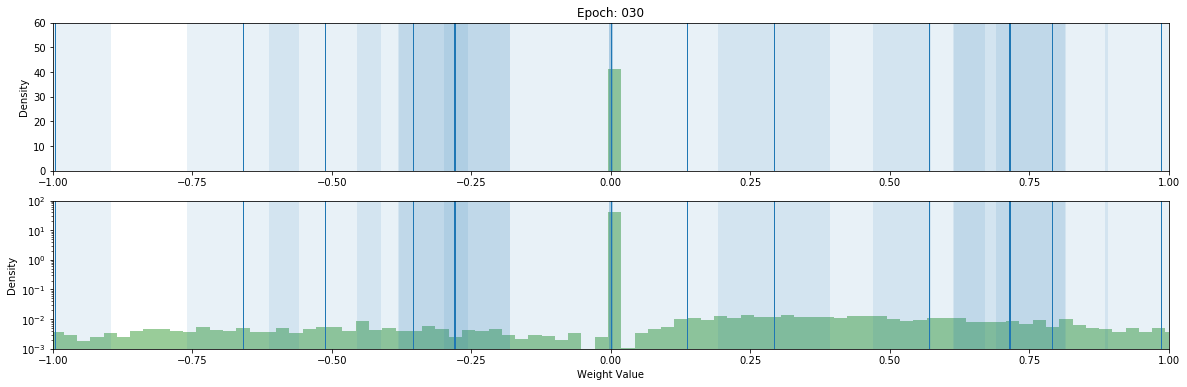

Epoch: 40. Test Accuracy: 95.65 Prune Accuracy: 95.11 Sparsity: 98.18


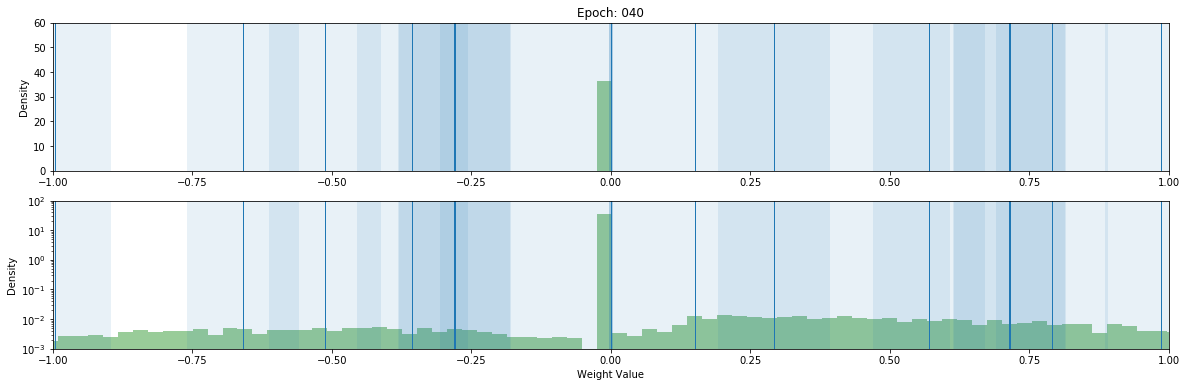

Epoch: 50. Test Accuracy: 95.73 Prune Accuracy: 95.10 Sparsity: 98.20


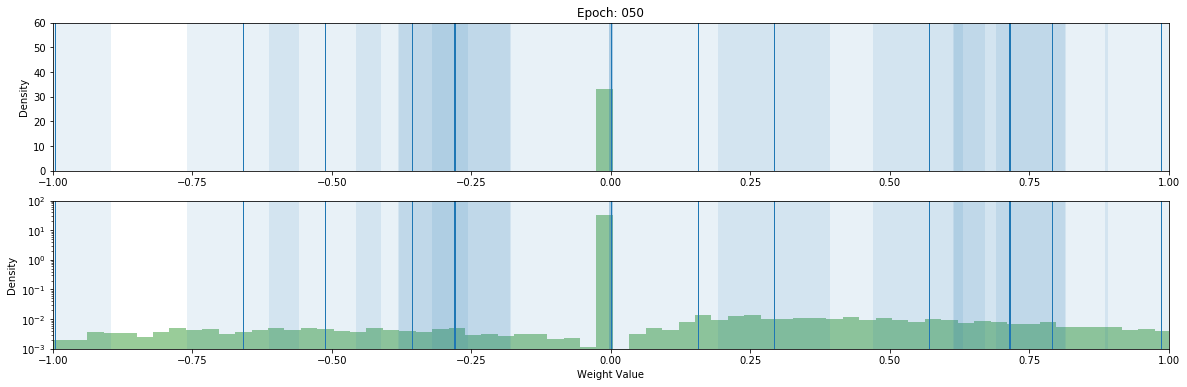

In [12]:
model_name = "LeNet_300_100"
data_size = "full"
model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)
model = torch.load(model_load_dir + model_file + '.m').cuda()

targets_dict = get_targets(model_file)
inputs = train_data(fetch = "data").cuda()
targets = torch.cat((targets_dict['fc1.out'],targets_dict['fc2.out'],targets_dict['fc3.out']), 1).data.cuda()
dataset = torch.utils.data.TensorDataset(inputs, targets)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

#Get targets at each layer
gmp = GaussianMixturePrior(16, [x for x in model.parameters()], 0.99, zero_ab = get_ab(2000, 1000), ab = get_ab(100,10), scaling = True)
opt_1 = torch.optim.Adam([{'params': model.fc1.parameters(), 'lr': 1e-4}])
opt_2 = torch.optim.Adam([{'params': model.fc2.parameters(), 'lr': 1e-4}])
opt_3 = torch.optim.Adam([{'params': model.fc3.parameters(), 'lr': 1e-4}])
opt_gmp = torch.optim.Adam([{'params': [gmp.means], 'lr': 3e-4}, {'params': [gmp.gammas, gmp.rhos], 'lr': 3e-3}, {'params': [gmp.scale], 'lr': 1e-6}])
tau = 1e-4

for epoch in range(retraining_epochs):
    for i, (images, targets) in enumerate(loader):
        images=images.cuda()
        targets=targets.cuda()
        images = Variable(images)
        targets = Variable(targets)	
        opt_1.zero_grad()
        opt_2.zero_grad()
        opt_3.zero_grad()
        opt_gmp.zero_grad()
        
        forward = model.layer_forward(images)
        loss_acc = nn.MSELoss()(forward, targets)
        
        loss = loss_acc + tau * gmp.call()
        loss.backward()
        
        opt_1.step()
        opt_2.step()
        opt_3.step()
        opt_gmp.step()
    if (trueAfterN(epoch, 10)):
        test_acc = test_accuracy(test_data_full, test_labels_full, model)
        prune_model = sws_prune_copy(model, gmp)
        prune_acc = test_accuracy(test_data_full, test_labels_full, prune_model)
        sparsity = get_sparsity(prune_model)
        print('Epoch: {}. Test Accuracy: {:.2f} Prune Accuracy: {:.2f} Sparsity: {:.2f}'.format(epoch+1, test_acc[0], prune_acc[0], sparsity))
        show_sws_weights(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch)

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2000.0 Variance: 1000.0
Non-zero component Mean: 100.0 Variance: 10.0
Layer Loss: 153907.891
Layer Loss: 168.665
Layer Loss: 21215.748
Layer Loss: 72.070
Layer Loss: 900.592
Layer Loss: 8.027
0-neglogprop Loss: -11055.582
Remaining-neglogprop Loss: -39147.242
Epoch: 10. Test Accuracy: 93.37 Prune Accuracy: 93.11 Sparsity: 97.96


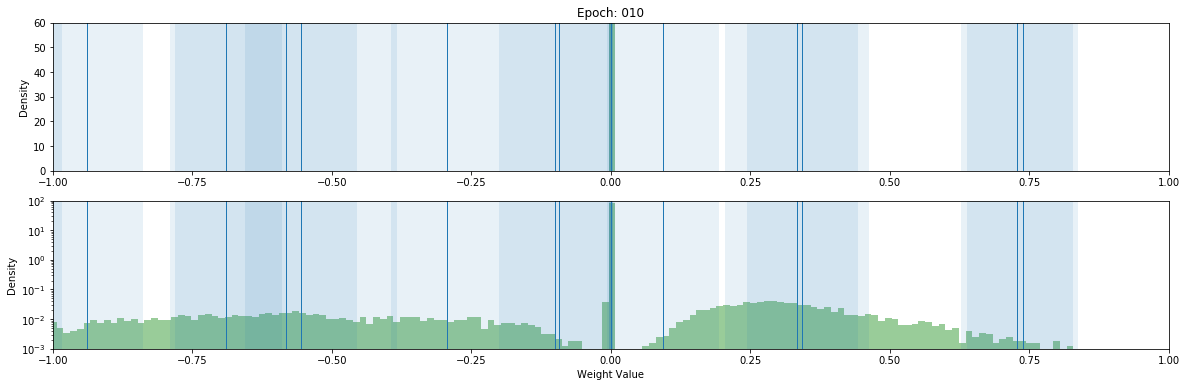

Epoch: 20. Test Accuracy: 94.89 Prune Accuracy: 94.44 Sparsity: 97.98


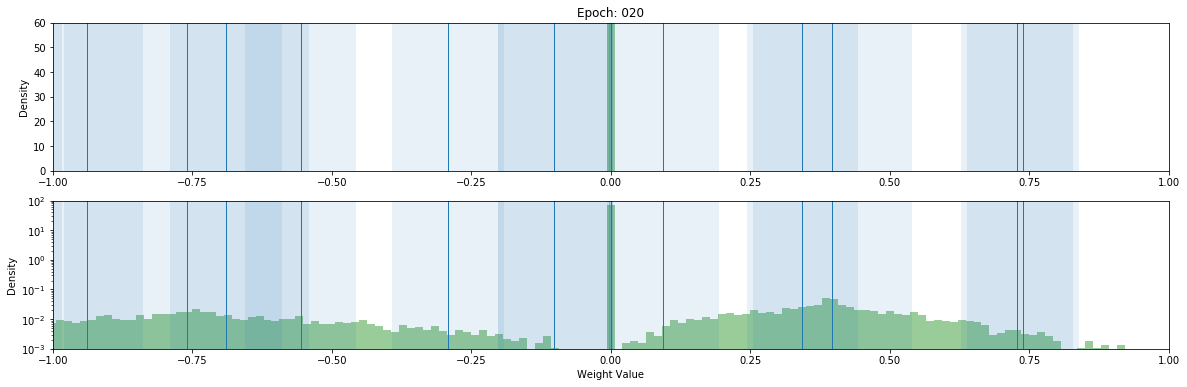

Epoch: 30. Test Accuracy: 95.38 Prune Accuracy: 94.86 Sparsity: 98.00


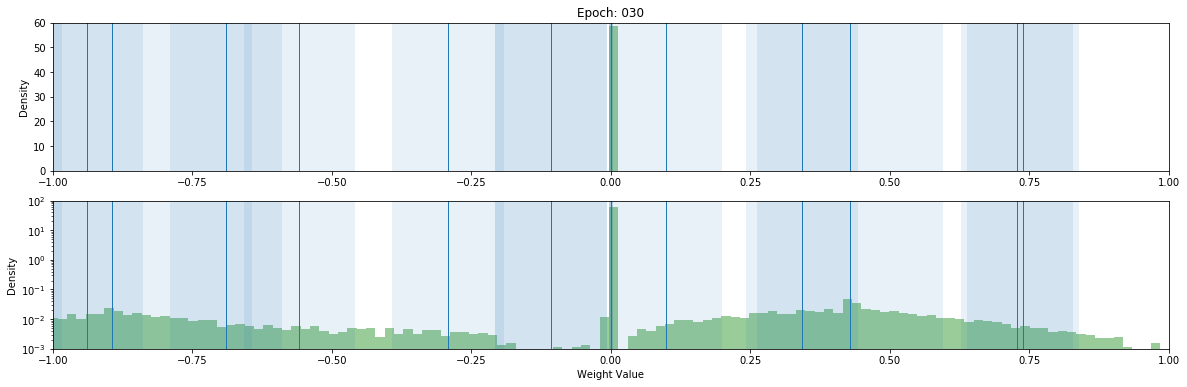

Epoch: 40. Test Accuracy: 95.57 Prune Accuracy: 94.88 Sparsity: 98.02


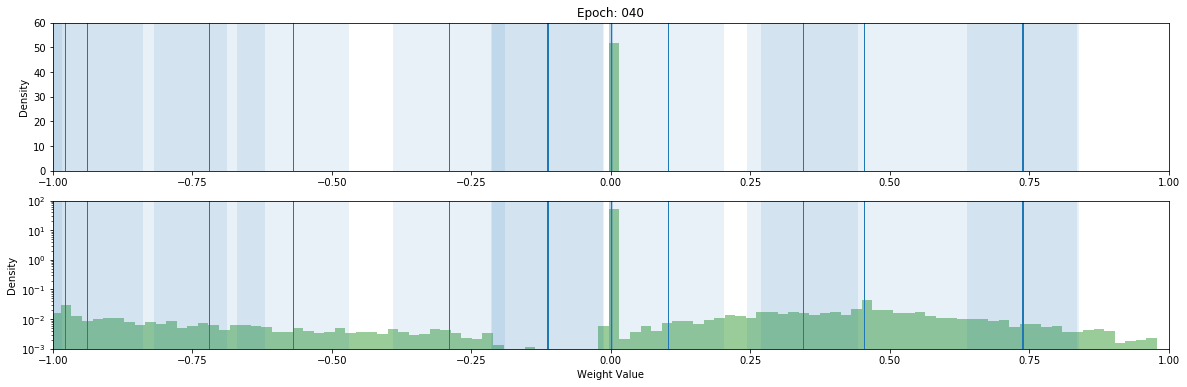

Epoch: 50. Test Accuracy: 95.63 Prune Accuracy: 95.05 Sparsity: 98.03


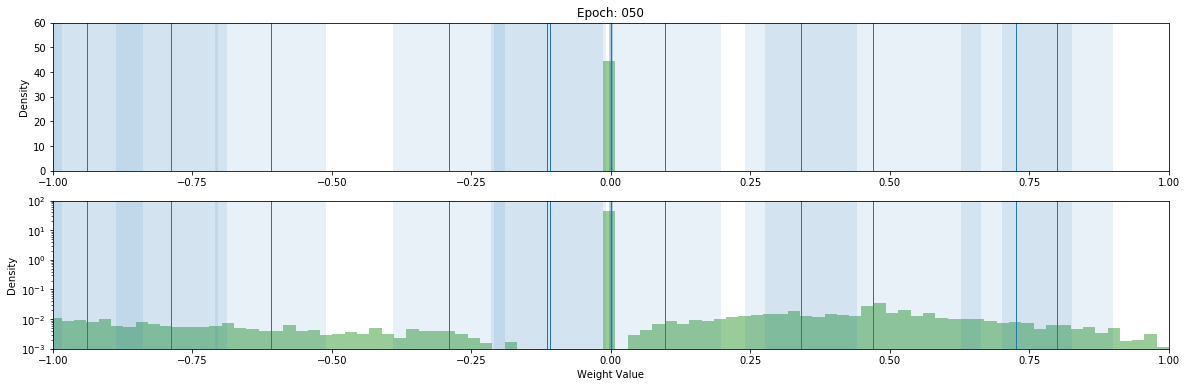

In [14]:
model_name = "LeNet_300_100"
data_size = "full"
model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)
model = torch.load(model_load_dir + model_file + '.m').cuda()

targets_dict = get_targets(model_file)
inputs = train_data(fetch = "data").cuda()
targets = torch.cat((targets_dict['fc1.out'],targets_dict['fc2.out'],targets_dict['fc3.out']), 1).data.cuda()
dataset = torch.utils.data.TensorDataset(inputs, targets)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

#Get targets at each layer
gmp = GaussianMixturePrior(16, [x for x in model.parameters()], 0.99, zero_ab = get_ab(2000, 1000), ab = get_ab(100,10), scaling = False)
opt_1 = torch.optim.Adam([{'params': model.fc1.parameters(), 'lr': 1e-4}])
opt_2 = torch.optim.Adam([{'params': model.fc2.parameters(), 'lr': 1e-4}])
opt_3 = torch.optim.Adam([{'params': model.fc3.parameters(), 'lr': 1e-4}])
opt_gmp = torch.optim.Adam([{'params': [gmp.means], 'lr': 3e-4}, {'params': [gmp.gammas, gmp.rhos], 'lr': 3e-3}])
tau = 1e-4

for epoch in range(retraining_epochs):
    for i, (images, targets) in enumerate(loader):
        images=images.cuda()
        targets=targets.cuda()
        images = Variable(images)
        targets = Variable(targets)	
        opt_1.zero_grad()
        opt_2.zero_grad()
        opt_3.zero_grad()
        opt_gmp.zero_grad()
        
        forward = model.layer_forward(images)
        loss_acc = nn.MSELoss()(forward, targets)
        
        loss = loss_acc + tau * gmp.call()
        loss.backward()
        
        opt_1.step()
        opt_2.step()
        opt_3.step()
        opt_gmp.step()
    if (trueAfterN(epoch, 10)):
        test_acc = test_accuracy(test_data_full, test_labels_full, model)
        prune_model = sws_prune_copy(model, gmp)
        prune_acc = test_accuracy(test_data_full, test_labels_full, prune_model)
        sparsity = get_sparsity(prune_model)
        print('Epoch: {}. Test Accuracy: {:.2f} Prune Accuracy: {:.2f} Sparsity: {:.2f}'.format(epoch+1, test_acc[0], prune_acc[0], sparsity))
        show_sws_weights(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch)

In [10]:
prune_model = sws_prune_copy(model, gmp)
prune_acc = test_accuracy(test_data_full, test_labels_full, prune_model)
sparsity = get_sparsity(prune_model)
print('Epoch: {}. Test Accuracy: {:.2f} Prune Accuracy: {:.2f} Sparsity: {:.2f}'.format(epoch+1, test_acc[0], prune_acc[0], sparsity))

Epoch: 50. Test Accuracy: 95.58 Prune Accuracy: 95.05 Sparsity: 98.01
